# ARCOS Pipeline in python

This notebook ilustrates a example workflow from images to ARCOS analysis and visualization in napari. It uses the python package stardist for segmenting nuclei, skimage for image processing and trackpy for tracking cells over time.
Subsequently ARCOS is used to analyse and detect collective events.

Example dataset is downloadable from: https://arcos.gitbook.io/home/example-use-cases/detecting-collective-signalling-events-in-epithelial-cells

### Imports

In [14]:
import os
import skimage
import numpy

from napari import Viewer
from stardist.models import StarDist2D
from csbdeep.utils import normalize
from skimage.measure import regionprops, regionprops_table
from skimage.util import map_array

import pandas as pd
# import trackpy
from arcos4py import ARCOS
from arcos4py.tools import estimate_eps
from arcos4py.validation import bootstrap_arcos
import errno

TAB20 = [
    "#1f77b4",
    "#aec7e8",
    "#ff7f0e",
    "#ffbb78",
    "#2ca02c",
    "#98df8a",
    "#d62728",
    "#ff9896",
    "#9467bd",
    "#c5b0d5",
    "#8c564b",
    "#c49c94",
    "#e377c2",
    "#f7b6d2",
    "#7f7f7f",
    "#c7c7c7",
    "#bcbd22",
    "#dbdb8d",
    "#17becf",
    "#9edae5",
]

### Custom Functions

In [15]:
def create_folders(path: str, folder: list):
    for i in folder:
        folder_to_make = os.path.join(path, i)
        try:
            os.makedirs(folder_to_make)
            print(f'folder "{i}" created')
        except OSError as e:
            print(f'folder "{i}" alrady exists')
            if e.errno != errno.EEXIST:
                raise
def remap_segmentation(df: pd.DataFrame, segmentation: list, timepoint_column: str = 'timepoint', label_column: str = 'label', measure_column: str = 'ERK') -> list:
    tracked_numpy = df[[timepoint_column, label_column, measure_column]].sort_values(timepoint_column).to_numpy()
    grouped_numpy = numpy.split(tracked_numpy,numpy.unique(tracked_numpy[:,0], return_index = True)[1][1:])
    ratio_remapped = []
    for img, grp in zip(segmentation, grouped_numpy):
        img_copy = map_array(img, grp[:,1], grp[:, 2])
        ratio_remapped.append(img_copy)
    return ratio_remapped

### Define variables and create output folders

In [16]:
PATH = 'example_data' # where you data is located   
FOLDER = 'mdck_ekar' # subfolder of PATH where images are stored
OUT_DATA = 'data' # subfolder of PATH where csv is stored
OUT_LABELS = 'stardist' # subfolder of PATH where stardist segmentation is stored
FILENAME = 'C3-041_Ori.tif'
full_path = os.path.join(PATH, FOLDER)
orig_images_path = os.path.join(PATH, FOLDER)
out_path_csv = os.path.join(PATH, OUT_DATA)
create_folders(PATH, [OUT_DATA, OUT_LABELS]) 

folder "data" alrady exists
folder "stardist" alrady exists


### Load segmentation model and image

In [ ]:
model = StarDist2D.from_pretrained('2D_versatile_fluo') # standard stardist model for 2d segmentation
image_data = skimage.io.imread(os.path.join(orig_images_path, FILENAME))

### Apply segmentation and extract data from images

In [ ]:
out_path_stardist = os.path.join(PATH, OUT_LABELS,  'stardist.tif')
segmentation = []
df = []

for t, tp_data in enumerate(image_data):
    print(f'analysing timepoint {t}')
    labels, _ = model.predict_instances(normalize(tp_data))
    labels = skimage.segmentation.clear_border(labels)
    dic = regionprops_table(labels, tp_data, properties=['label', 'centroid', 'intensity_mean', 'area'])
    dic['timepoint'] = numpy.repeat(t, len(dic['label']))
    df.append(pd.DataFrame(dic))
    skimage.segmentation.clear_border(labels)
    segmentation.append(labels)

# optionally save segmentation
# skimage.io.imsave(out_path_stardist, numpy.stack(segmentation))

### Track nuclei and export data as csv

In [ ]:
import trackpy
df_full = pd.concat(df)
df_full = df_full.rename(columns={"centroid-1": "x", "centroid-0": "y", 'intensity_mean': 'ERK'})
df_full = df_full.sort_values(['timepoint'])
df_tracked = trackpy.link_df(df_full, search_range = 10, memory = 2, t_column = 'timepoint')
df_tracked = df_tracked.reset_index(drop=True).rename(columns={'particle': "track_id"})
# df_tracked.to_csv(out_path_csv+'\\tracked_data_fret.csv')

In [4]:
df_tracked = pd.read_csv(out_path_csv+'\\tracked_data_fret.csv')

### Detect Collective events with ARCOS

In [5]:
ts = ARCOS(df_tracked, ["x", "y"], 'timepoint','track_id', 'ERK')
ts.interpolate_measurements()
ts.bin_measurements(bias_method='none', binarization_threshold=0.65)


,Unnamed: 0,label,y,x,ERK,area,timepoint,track_id,ERK.resc,ERK.bin
0,0,1,234.036101,234.216606,24.241877,277.0,0,0,0.579005,0
1,192,1,234.508772,235.382456,24.007018,285.0,1,0,0.570780,0
2,283,2,234.652174,234.163043,23.923913,276.0,2,0,0.570780,0
3,423,2,234.516129,234.562724,24.114695,279.0,3,0,0.574551,0
4,633,1,234.379061,234.534296,24.314079,277.0,4,0,0.574551,0
...,...,...,...,...,...,...,...,...,...,...
28036,26966,3,11.401442,17.651442,17.944712,416.0,192,186,0.362880,0
28037,27094,2,11.457500,16.387500,18.182500,400.0,193,186,0.366788,0
28038,27190,169,50.645833,288.500000,20.645833,48.0,193,187,0.453061,0
28039,27489,169,50.488372,289.813953,21.093023,43.0,195,187,0.453061,0


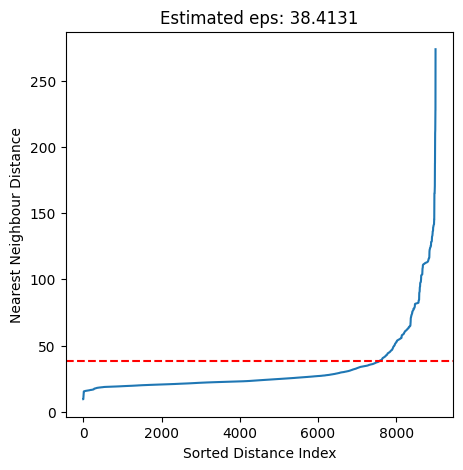

In [6]:
eps = estimate_eps(ts.data.query('`ERK.bin` == 1'), method='kneepoint', position_columns=["x", "y"], frame_column='timepoint', n_neighbors=3)

In [7]:
df_arcos = ts.track_collective_events(eps=eps, min_clustersize=3)

100%|██████████| 200/200 [00:01<00:00, 176.01it/s]


### Filter Collective events

In [8]:
from arcos4py.tools import filterCollev

filterer = filterCollev(df_arcos, 'timepoint', 'clTrackID', 'track_id')
ts_filtered = filterer.filter(25, 10)

In [9]:
ts_filtered

,Unnamed: 0,label,y,x,ERK,area,timepoint,track_id,ERK.resc,ERK.bin,clTrackID
28,5881,66,161.197411,133.915858,29.385113,309.0,41,69,0.759136,1,5
29,5891,92,132.793605,118.090116,29.494186,344.0,41,122,0.748303,1,5
30,5840,29,150.071685,150.627240,26.971326,279.0,41,134,0.674598,1,5
31,5927,117,128.785294,140.032353,30.202941,340.0,41,140,0.787779,1,5
32,5960,5,140.816393,186.196721,28.760656,305.0,42,9,0.737266,1,5
...,...,...,...,...,...,...,...,...,...,...,...
3813,27912,4,229.560724,267.974160,28.976744,387.0,199,115,0.744834,1,6
3814,27995,108,266.013158,156.743421,29.243421,304.0,199,116,0.754174,1,6
3815,28017,120,229.716867,181.132530,27.144578,332.0,199,123,0.680666,1,6
3816,28035,152,71.770642,226.636086,28.342508,327.0,199,125,0.722621,1,9


### Plot Noodleplot

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Time Point', ylabel='Position'>)

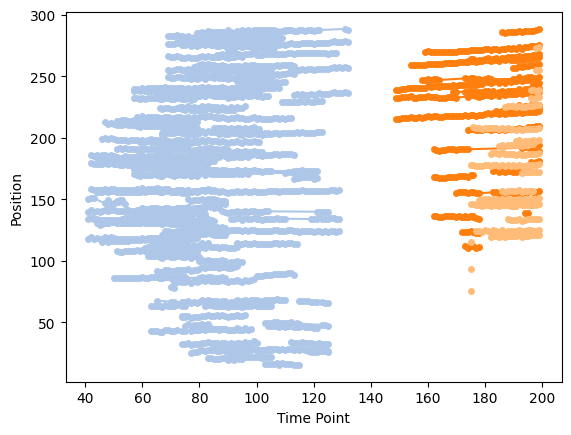

In [10]:
# from arcos4py.plotting import NoodlePlot
from matplotlib import pyplot as plt
from arcos4py.plotting import NoodlePlot

NoodlePlot(ts_filtered, 'clTrackID', 'track_id', 'timepoint', 'x', 'y', marker='o', linestyle="-", markersize=4).plot('x')

In [ ]:
np_data = df_tracked[['track_id', 'timepoint', 'y', 'x']].to_numpy()
colors = numpy.take(numpy.array(TAB20), ts_filtered['clTrackID'].unique(), mode="wrap")
df_w_colors = pd.merge(ts_filtered, pd.DataFrame(data={'colors': colors, 'clTrackID': ts_filtered['clTrackID'].unique()}))
points_data = df_w_colors[['timepoint', 'y', 'x']].to_numpy()
colors_data = df_w_colors['colors'].to_numpy('str')

### Remap measured Ratio to segmentation labels

In [ ]:
ratio_remapped = numpy.stack(remap_segmentation(df_tracked, segmentation))

### Add various layers to napari

In [ ]:
viewer = Viewer()
viewer.add_image(image_data, name='ERK Ratio image', colormap='inferno')
viewer.add_image(ratio_remapped, colormap='viridis')
viewer.add_labels(numpy.stack(segmentation), name='segmentation', visible=False)
viewer.add_tracks(np_data, name='cell tracks')
viewer.add_points(points_data, face_color=colors_data, name='collective events')

## Perform validation

In [11]:
from arcos4py.validation import bootstrap_arcos

Resampling data using method "shuffle_tracks"...


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]


Running ARCOS and calculating "['total_size', 'duration']"...


100%|██████████| 101/101 [00:35<00:00,  2.82it/s]


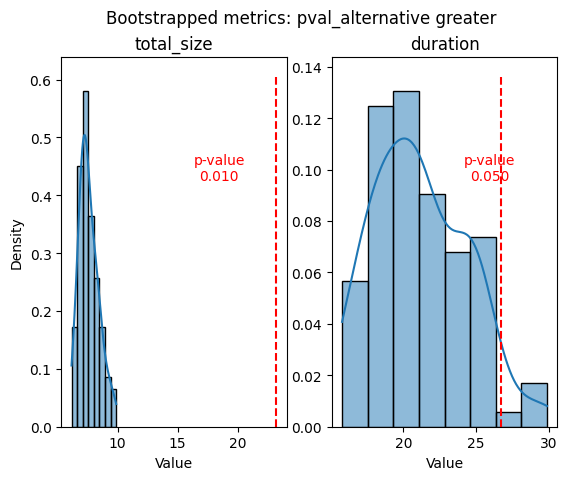

In [13]:
df = bootstrap_arcos(
    df=df_tracked,
    position_columns=["x", "y"],
    frame_column='timepoint',
    obj_id_column='track_id',
    measurement_column='ERK',
    method='shuffle_tracks',
    binarization_threshold=0.65,
    bias_method='none',
    eps=eps,
    min_clustersize=3,
    min_duration=2,
    min_total_size=3,
    n=100,
    parallel_processing=True,
)